In [1]:
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# from astropy.io import fits
import pdb
from scipy.ndimage.filters import maximum_filter1d
import glob
import fitsio as fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.normal import Normal
from tqdm import tqdm

In [2]:
import sys
sys.path.insert(0, '../')
sys.path.insert(1, '../latent_ode/')
import latent_ode.lib as ode
import latent_ode.lib.utils as utils
from latent_ode.lib.latent_ode import LatentODE
from latent_ode.lib.encoder_decoder import Encoder_z0_ODE_RNN, Decoder
from latent_ode.lib.diffeq_solver import DiffeqSolver
from latent_ode.lib.ode_func import ODEFunc

In [3]:
from latent_rnn import create_LatentODE_model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading

In [5]:
obsrv_std = torch.Tensor([0.01]).to(device)
z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))
input_dim = 1
model = create_LatentODE_model(input_dim, z0_prior, obsrv_std)

In [6]:
state = torch.load('latent_ode_state.pth.tar')

In [7]:
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [8]:
model.eval()

LatentODE(
  (encoder_z0): Encoder_z0_ODE_RNN(
    (GRU_update): GRU_unit(
      (update_gate): Sequential(
        (0): Linear(in_features=42, out_features=32, bias=True)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=20, bias=True)
        (3): Sigmoid()
      )
      (reset_gate): Sequential(
        (0): Linear(in_features=42, out_features=32, bias=True)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=20, bias=True)
        (3): Sigmoid()
      )
      (new_state_net): Sequential(
        (0): Linear(in_features=42, out_features=32, bias=True)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=40, bias=True)
      )
    )
    (z0_diffeq_solver): DiffeqSolver(
      (ode_func): ODEFunc(
        (gradient_net): Sequential(
          (0): Linear(in_features=20, out_features=16, bias=True)
          (1): Tanh()
          (2): Linear(in_features=16, out_features=16, bias=True)
          (3): Tanh()
          (4): Linear(in_fea

In [9]:
loader = torch.load('tess_cv.pt')

## Inference

In [10]:
data.keys()

NameError: name 'data' is not defined

In [12]:
res = []
for batch in tqdm(loader):
    observed = batch['observed_data']
    mask = batch['observed_mask']
    x = torch.cat((observed, mask), -1)
    t = batch['observed_tp']
    z_u, z_std = model.encoder_z0.forward(x, t)
    z_u = z_u.squeeze()
    z_u = z_u.detach().cpu().numpy()
    res.append(z_u)

100%|██████████| 8/8 [00:03<00:00,  2.52it/s]


In [19]:
res = np.concatenate(res)

In [20]:
res.shape

(2000, 10)

### TSNE

In [21]:
from sklearn.manifold import TSNE

In [28]:
tsne = TSNE(perplexity=10)

In [29]:
x = tsne.fit_transform(res)

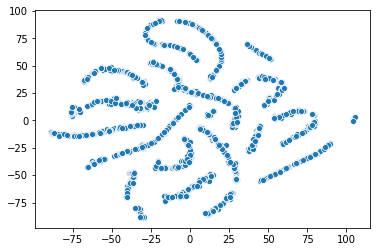

In [30]:
sns.scatterplot(x=x[:,0], y=x[:,1])

### Reconstruct

In [31]:
batch_dict = next(iter(loader))

In [32]:
batch_dict.keys()

dict_keys(['observed_data', 'observed_tp', 'data_to_predict', 'tp_to_predict', 'observed_mask', 'mask_predicted_data', 'labels', 'mode'])

In [33]:
t_obs = batch_dict['observed_tp']
y_obs = batch_dict['observed_data']

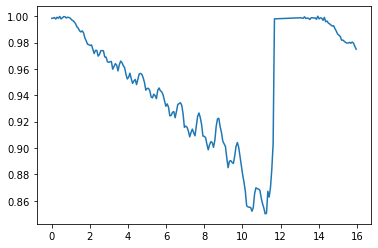

In [34]:
sns.lineplot(x=t_obs.squeeze().detach().cpu().numpy(), y=y_obs[20].squeeze().detach().cpu().numpy())

In [35]:
observed = batch_dict['observed_data']
mask = batch_dict['observed_mask']
x = torch.cat((observed, mask), -1)

In [36]:
n_traj_samples = 5

In [37]:
pred_x, info = model.get_reconstruction(batch_dict["tp_to_predict"], 
			batch_dict["observed_data"], batch_dict["observed_tp"], 
			mask = batch_dict["observed_mask"], n_traj_samples = n_traj_samples,
			mode = batch_dict["mode"])

In [38]:
batch_dict["tp_to_predict"].shape

torch.Size([38])

In [39]:
pred_x.shape

torch.Size([5, 256, 38, 1])

In [40]:
y_pred = pred_x[0].squeeze()

In [41]:
y_pred.shape

torch.Size([256, 38])

In [42]:
# model.decoder.forward(pred_x)

In [43]:
t_pred = batch_dict['tp_to_predict'].detach().cpu().numpy()

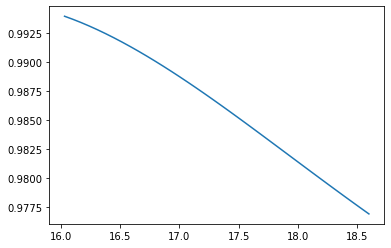

In [44]:
sns.lineplot(x=t_pred, y=y_pred[20].squeeze().detach().cpu().numpy())

In [45]:
y_true = batch['data_to_predict']

In [46]:
y_true.shape

torch.Size([208, 38, 1])

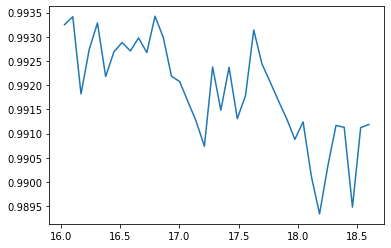

In [47]:
sns.lineplot(x=t_pred, y=y_true[20].squeeze().detach().cpu().numpy())

In [78]:
tt = torch.arange(0, 30, 0.01)

In [79]:
res2 = model.sample_traj_from_prior(tt, 10)

In [80]:
res2.shape

torch.Size([10, 1, 3000, 1])

In [81]:
# ts2 = batch['observed_tp'].detach().cpu().numpy()

In [82]:
res2 = res2.squeeze()

In [83]:
res2 = res2.detach().cpu().numpy()

In [84]:
res2.shape

(10, 3000)

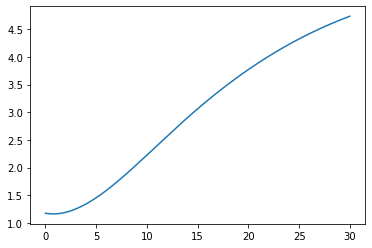

In [91]:
sns.lineplot(x=tt, y=res2[9])